<a href="https://colab.research.google.com/github/patrick22414/colab-FLOPs/blob/main/FLOPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ptflops

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.models import mobilenet_v2

import ptflops

In [ ]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, *, kernel_size, stride, expansion=None, mid_channels=None):
        super().__init__()

        assert expansion or mid_channels
        if not mid_channels:
            mid_channels = in_channels * expansion

        self.inv_bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
        )

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(
                mid_channels,
                mid_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=kernel_size // 2,
                groups=mid_channels,
                bias=False,
            ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
        )

        self.pointwise_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.use_shortcut = (stride == 1 and in_channels == out_channels)

    def forward(self, x):
        y = self.inv_bottleneck(x)
        y = self.depthwise_conv(y)
        y = self.pointwise_conv(y)
        if self.use_shortcut:
            y = y + x

        return y


class MBStage(nn.Module):
    def __init__(self, num_blocks, in_channels, out_channels, *, kernel_size, stride, expansion=None, mid_channels=None):
        super().__init__()

        assert expansion or mid_channels
        if not isinstance(expansion, list):
            expansion = [expansion] * num_blocks
        if not isinstance(mid_channels, list):
            mid_channels = [mid_channels] * num_blocks

        self.blocks = nn.Sequential(*[
            MBConv(
                in_channels if i == 0 else out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride if i == 0 else 1,
                expansion=e,
                mid_channels=mc,
            )
            for i, (e, mc) in enumerate(zip(expansion, mid_channels))
        ])

    def forward(self, x):
        y = self.blocks(x)

        return y


class MobileNetV3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            MBConv(16, 16, kernel_size=3, stride=1, mid_channels=16)
        )
        self.stages = nn.Sequential(
            MBStage(2, 16, 24, kernel_size=3, stride=2, mid_channels=[64, 72]),
            MBStage(3, 24, 40, kernel_size=5, stride=2, expansion=3),
            MBStage(4, 40, 80, kernel_size=3, stride=2, mid_channels=[240, 200, 184, 184]),
            MBStage(2, 80, 112, kernel_size=3, stride=1, expansion=6),
            MBStage(3, 112, 160, kernel_size=5, stride=2, expansion=6),
        )
        self.one_more = nn.Sequential(
            nn.Conv2d(160, 960, kernel_size=1, bias=False),
            nn.BatchNorm2d(960),
            nn.ReLU(),
        )
        # self.classifier = nn.Sequential(
        #     nn.AdaptiveAvgPool2d(1),
        #     nn.Conv2d(960, 1280, kernel_size=1, bias=False),
        #     nn.ReLU(),
        #     nn.Conv2d(1280, 1000, kernel_size=1, bias=False),
        # )

    def forward(self, x):
        y = self.stem(x)
        y = self.stages(y)
        y = self.one_more(y)

        return y

class EfficientNetB0(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            MBConv(32, 16, kernel_size=3, stride=1, expansion=1)
        )
        self.stages = nn.Sequential(
            MBStage(2, 16, 24, kernel_size=3, stride=2, expansion=6),
            MBStage(2, 24, 40, kernel_size=5, stride=2, expansion=6),
            MBStage(3, 40, 80, kernel_size=3, stride=2, expansion=6),
            MBStage(3, 80, 112, kernel_size=5, stride=1, expansion=6),
            MBStage(4, 112, 192, kernel_size=5, stride=2, expansion=6),
            MBStage(1, 192, 320, kernel_size=3, stride=1, expansion=6),
        )
        self.one_more = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(),
        )
        # self.classifier = nn.Sequential(
        #     nn.AdaptiveAvgPool2d(1),
        #     nn.Conv2d(1280, 1000, kernel_size=1, bias=False),
        # )

    def forward(self, x):
        y = self.stem(x)
        y = self.stages(y)
        y = self.one_more(y)

        return y

MACs: 370241360.0; Params: 1459960
MACs: 375179136.0; Params: 1459960
MACs: 375179136.0; Params: 1459960
MACs: 375880976.0; Params: 1459960
MACs: 375880976.0; Params: 1459960
MACs: 377857616.0; Params: 1459960
MACs: 377857616.0; Params: 1459960
MACs: 378569376.0; Params: 1459960
MACs: 378569376.0; Params: 1459960
MACs: 418856120.0; Params: 1459960
MACs: 418856120.0; Params: 1459960
MACs: 419577800.0; Params: 1459960
MACs: 419577800.0; Params: 1459960
MACs: 421609800.0; Params: 1459960
MACs: 421609800.0; Params: 1459960
MACs: 422341400.0; Params: 1459960
MACs: 422341400.0; Params: 1459960
MACs: 427558280.0; Params: 1459960
MACs: 427558280.0; Params: 1459960
MACs: 428299800.0; Params: 1459960
MACs: 428299800.0; Params: 1459960
MACs: 430387160.0; Params: 1459960
MACs: 430387160.0; Params: 1459960
MACs: 431138600.0; Params: 1459960
MACs: 431138600.0; Params: 1459960
MACs: 454427856.0; Params: 1459960
MACs: 454427856.0; Params: 1459960
MACs: 455189216.0; Params: 1459960
MACs: 455189216.0; P

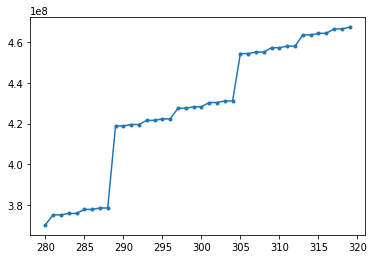

In [ ]:
# x = torch.randn(10, 3, 300, 300)
macs = []
for r in range(280, 320, 1):
    input_size = (3, r, r)

    mbv3 = MobileNetV3()
    res = ptflops.get_model_complexity_info(
        mbv3,
        input_size,
        as_strings=False,
        print_per_layer_stat=False,
    )
    macs.append(res[0])
    print("MACs: {}; Params: {}".format(*res))

from matplotlib import pyplot
pyplot.plot(list(range(280, 320, 1)), macs, ".-")
pyplot.show()
# enb0 = EfficientNetB0()
# res = ptflops.get_model_complexity_info(
#     enb0,
#     input_size,
#     print_per_layer_stat=False,
# )
# print("MACs: {}; Params: {}".format(*res))